In [1]:
import os
import torch
import pathlib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")


2024-03-30 06:34:58.083650: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 06:34:58.083828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 06:34:58.252949: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class Datasets:
    def __init__(self, data_dir):
        self.data_dir = data_dir

    def define_paths(self):
        filepaths = []
        labels = []

        folds = os.listdir(self.data_dir)
        for fold in folds:
            foldpath = os.path.join(self.data_dir, fold)
            # check the folders from the main directory. If there are other files, ignore them
            if pathlib.Path(foldpath).suffix != '':
                continue

            filelist = os.listdir(foldpath)
            for file in filelist:
                fpath = os.path.join(foldpath, file)

                # check if there are other folders
                if pathlib.Path(foldpath).suffix == '':
                    # check unneeded masks
                    if pathlib.Path(fpath).parts[-1] == 'masks' or pathlib.Path(fpath).parts[-1] == 'Masks' or \
                            pathlib.Path(fpath).parts[-1] == 'MASKS':
                        continue
                    else:
                        o_file = os.listdir(fpath)
                        for f in o_file:
                            ipath = os.path.join(fpath, f)
                            filepaths.append(ipath)
                            labels.append(fold)

                else:
                    filepaths.append(fpath)
                    labels.append(fold)

        return filepaths, labels

    def define_df(self, files, classes):
        Fseries = pd.Series(files, name='filepaths')
        Lseries = pd.Series(classes, name='labels')
        return pd.concat([Fseries, Lseries], axis=1)

    def split_data(self):
        files, classes = self.define_paths()
        df = self.define_df(files, classes)
        strat = df['labels']
        train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)
        strat = dummy_df['labels']
        valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

        return train_df, valid_df, test_df

In [3]:
class DataLoaders:
    def __init__(self, train_df, valid_df, test_df, batch_size):
        self.train_df = train_df
        self.valid_df = valid_df
        self.test_df = test_df
        self.batch_size = batch_size

    def create_gens(self):
        img_size = (224, 224)
        channels = 3
        color = 'rgb'
        img_shape = (img_size[0], img_size[1], channels)

        def scalar(img):
            return img

        tr_gen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
        ts_gen = ImageDataGenerator(preprocessing_function=scalar)

        train_gen = tr_gen.flow_from_dataframe(
            self.train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
            color_mode=color, shuffle=True, batch_size=self.batch_size)

        valid_gen = ts_gen.flow_from_dataframe(self.valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                               class_mode='categorical',
                                               color_mode=color, shuffle=True, batch_size=self.batch_size)

        ts_length = len(self.test_df)
        test_batch_size = max(
            sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
        test_steps = ts_length // test_batch_size

        test_gen = ts_gen.flow_from_dataframe(self.test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                              class_mode='categorical',
                                              color_mode=color, shuffle=False, batch_size=test_batch_size)

        return train_gen, valid_gen, test_gen

In [4]:
class Model:
    def __init__(self, img_shape, num_classes):
        self.img_shape = img_shape
        self.num_classes = num_classes

    def create_model(self):
        model = keras.Sequential([
            layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=self.img_shape),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
           layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

In [5]:
# 设置数据集路径，加载数据
data_dir = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'
datasets = Datasets(data_dir)
train_df, valid_df, test_df = datasets.split_data()

In [6]:
# 使用GPU加速运算
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [7]:
# 加载数据
batch_size = 32
data_loaders = DataLoaders(train_df, valid_df, test_df, batch_size)
train_gen, valid_gen, test_gen = data_loaders.create_gens()



Found 16932 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.


In [8]:
# 定义输入图片形状和类别总数
img_shape = (224, 224, 3)  # Adjust the image shape if necessary
num_classes = len(train_df['labels'].unique())

In [9]:
epochs = 10 

# 建立实例模型并训练
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 指定使用的GPU设备编号
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"  # 启用GPU内存增长模式
model = Model(img_shape, num_classes).create_model()
history = model.fit(train_gen, validation_data=valid_gen, epochs=epochs)

Epoch 1/10


2024-03-28 12:39:30.244163: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49284: 7.84353, expected 6.92193
2024-03-28 12:39:30.244237: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49286: 7.76792, expected 6.84632
2024-03-28 12:39:30.244268: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49287: 6.15631, expected 5.23472
2024-03-28 12:39:30.244282: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49288: 6.71859, expected 5.797
2024-03-28 12:39:30.244292: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49289: 7.43913, expected 6.51753
2024-03-28 12:39:30.244303: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49290: 7.1783, expected 6.25671
2024-03-28 12:39:30.244314: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49291: 6.06838, expected 5.14679
2024-03-28 12:39:30.244325: E 

  1/530 ━━━━━━━━━━━━━━━━━━━━ 1:34:15 11s/step - accuracy: 0.2812 - loss: 52.4204

I0000 00:00:1711629575.523221     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


484/530 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step - accuracy: 0.4565 - loss: 289.3231 

2024-03-28 12:41:19.684621: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147863: 4.20057, expected 3.56758
2024-03-28 12:41:19.684690: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 148112: 5.2774, expected 4.6444
2024-03-28 12:41:19.684702: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 148733: 5.23249, expected 4.59949
2024-03-28 12:41:19.684712: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149184: 4.9994, expected 4.36641
2024-03-28 12:41:19.684720: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149297: 5.27461, expected 4.64162
2024-03-28 12:41:19.684728: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149315: 5.15052, expected 4.51753
2024-03-28 12:41:19.684736: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149353: 5.2018, expected 4.5688
2024-03-28 12:41:19.68474

530/530 ━━━━━━━━━━━━━━━━━━━━ 142s 248ms/step - accuracy: 0.4583 - loss: 269.0557 - val_accuracy: 0.4816 - val_loss: 1.2462
Epoch 2/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 66s 123ms/step - accuracy: 0.4854 - loss: 1.2261 - val_accuracy: 0.4816 - val_loss: 1.2016
Epoch 3/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 64s 119ms/step - accuracy: 0.4868 - loss: 1.1924 - val_accuracy: 0.4816 - val_loss: 1.1922
Epoch 4/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 63s 118ms/step - accuracy: 0.4855 - loss: 1.1834 - val_accuracy: 0.4816 - val_loss: 1.1856
Epoch 5/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 64s 119ms/step - accuracy: 0.4763 - loss: 1.1910 - val_accuracy: 0.4816 - val_loss: 1.1925
Epoch 6/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 63s 118ms/step - accuracy: 0.4859 - loss: 1.1836 - val_accuracy: 0.4816 - val_loss: 1.1876
Epoch 7/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 63s 117ms/step - accuracy: 0.4839 - loss: 1.1845 - val_accuracy: 0.4816 - val_loss: 1.1859
Epoch 8/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 64s 119ms/step - accuracy: 0.4886 - loss: 1.1816 - 

In [10]:
# 评估指标
test_loss, test_acc = model.evaluate(test_gen)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

2024-03-28 12:51:25.897913: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50572: 4.6624, expected 4.08943
2024-03-28 12:51:25.897972: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 52293: 4.68104, expected 4.10807
2024-03-28 12:51:25.897984: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 52836: 4.30357, expected 3.73059
2024-03-28 12:51:25.897999: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 54546: 4.66986, expected 4.09689
2024-03-28 12:51:25.898010: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 55276: 4.66577, expected 4.09279
2024-03-28 12:51:25.898028: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 57708: 4.28907, expected 3.7161
2024-03-28 12:51:25.898036: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 57732: 4.7085, expected 4.13552
2024-03-28 12:51:25.898044: E 

29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 675ms/step - accuracy: 0.4599 - loss: 1.2057
Test Loss: 1.1862339973449707, Test Accuracy: 0.48134151101112366


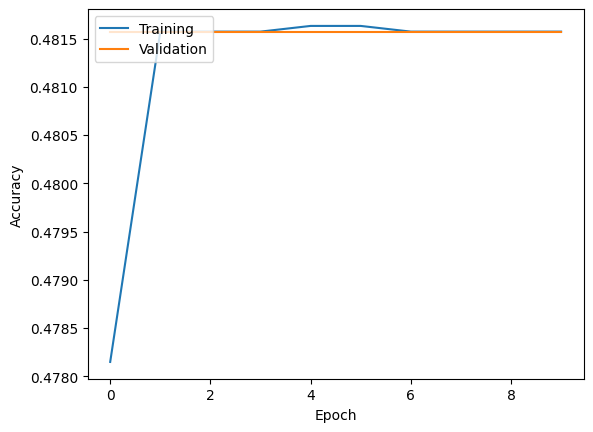

In [11]:
# 结果可视化，训练与验证集上的准确率曲线
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()